<a href="https://colab.research.google.com/github/sushmit14/Jigsaw-AI/blob/main/Tamu_datathon_puzzle_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import pandas as pd 
import tensorflow_hub as hub
import os
import cv2
import glob
from tensorflow import keras
from keras.preprocessing import image
from matplotlib.pyplot import imread
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb
from google.colab.patches import cv2_imshow
from google.colab import files
import math
import tensorflow as tf
import numpy as np
from glob import glob
from PIL import Image
from itertools import permutations
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive

'Colab Notebooks'   train.zip


In [ ]:
! mkdir total
! unzip drive/MyDrive/train.zip -d total

mkdir: cannot create directory ‘total’: File exists
Archive:  drive/MyDrive/train.zip
replace total/__MACOSX/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
n
n


In [ ]:
path_list_train = []
path_list_test = []
path_list_val = []
index = 0
def get_path(files):
  path_list = []
  flag = 0
  global index
  for path in files:
    path_list.append(path)
    index = index + 1
  for i in range(0,len(path_list),1):
    if(i<0.9*len(path_list)):
      path_list_train.append(path_list[i])
    elif(i<0.98*len(path_list)):
      path_list_test.append(path_list[i])
    else:
      path_list_val.append(path_list[i])

In [ ]:
import pathlib
for path in glob('/content/total/train/*'):
  path = path + '/*'
  get_path(glob(path))
np.random.shuffle(path_list_train)
np.random.shuffle(path_list_test)
np.random.shuffle(path_list_val)
print(len(path_list_train),len(path_list_test),len(path_list_val))

45176 2492 2060


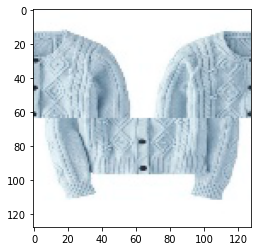

In [ ]:
def to_np(indx):
    img = cv2.imread(path_list_test[indx])
    return img

plt.imshow(to_np(0))

In [ ]:
def get_pieces(img, rows, cols, row_cut_size, col_cut_size):
    pieces = []
    for r in range(0, rows, row_cut_size):
        for c in range(0, cols, col_cut_size):
            pieces.append(img[r:r+row_cut_size, c:c+col_cut_size, :])
    return pieces

# Splits an image into uniformly sized puzzle pieces
def get_uniform_rectangular_split(img, puzzle_dim_x, puzzle_dim_y):
    rows = img.shape[0]
    cols = img.shape[1]
    if rows % puzzle_dim_y != 0 or cols % puzzle_dim_x != 0:
        print('Please ensure image dimensions are divisible by desired puzzle dimensions.')
    row_cut_size = rows // puzzle_dim_y
    col_cut_size = cols // puzzle_dim_x

    pieces = get_pieces(img, rows, cols, row_cut_size, col_cut_size)

    return pieces

In [ ]:
import cv2
#GETS IMAGE ARRAY OUT GIVEN AN IMAGE PATH
def get_input(path):
    im = cv2.imread(path)
    return(im)
 
#CREATES LABEL VECTOR [0,1] OR [1,0] BY EXPLOITING CLASS TYPE label_files IN FILE PATH 
def get_output(path):
    img_id = path.split('/')[-2]
    return img_id

#GENERATOR FUNCTION TO PASS THE IMAGES AND LABELS TO model.fit FOR TRAINING
def image_generator(files, batch_size= 128, resize=(200, 200)):
 
      while True:
          batch_paths  = np.random.choice(a  = files, 
                                          size = batch_size)
          batch_x = []
          batch_y = [] 
          
          for input_path in batch_paths:
              input = get_input(input_path)
              output = get_output(input_path)
              if resize is not None:
                input = cv2.resize(input, resize)
              #input  = input[np.newaxis,:,:,:]
              input = np.array(get_uniform_rectangular_split(input, 2, 2))
              batch_x.append(input)
              #batch_y.append((get_mask(input),output))
              batch_y.append(label_dict[output])
              
          batch_x = np.array(batch_x).astype(np.float32)
          batch_x = batch_x / 255.0
          batch_y = np.array(batch_y)
          #batch_x = patch_encoder(batch_x)
          yield batch_x, batch_y

In [ ]:
label_dict = {
    '0123' : 0,
    '0132' : 1,
    '0213' : 2,
    '0231' : 3,
    '0312' : 4,
    '0321' : 5,
    '1023' : 6,
    '1032' : 7,
    '1203' : 8,
    '1230' : 9,
    '1302' : 10,
    '1320' : 11,
    '2013' : 12,
    '2031' : 13,
    '2103' : 14,
    '2130' : 15,
    '2301' : 16,
    '2310' : 17,
    '3012' : 18,
    '3021' : 19,
    '3102' : 20,
    '3120' : 21,
    '3201' : 22,
    '3210' : 23
}

In [ ]:
label_dict_rev = {
      0 : '0123',
       1 : '0132',
        2: '0213',
        3: '0231',
        4: '0312',
        5: '0321',
        6: '1023',
        7: '1032',
        8: '1203',
        9: '1230',
        10: '1302',
        11: '1320',
        12: '2013', 
        13: '2031', 
        14: '2103',
        15: '2130', 
        16: '2301',
        17: '2310',
        18: '3012',
        19: '3021',
        20: '3102', 
        21: '3120', 
        22: '3201', 
        23: '3210'
    }

In [ ]:
train_x, train_y =[], []
test_x, test_y =[], []


for i in range(2492):
    resized = cv2.resize(to_np(i), (200, 200))
    test_x.append(get_uniform_rectangular_split(resized, 2, 2))
    img_id = path_list_test[i].split('/')[-2]
    test_y.append(label_dict[img_id])

In [ ]:
def to_np_val(indx):
    img = cv2.imread(path_list_val[indx])
    return img

In [ ]:
val_x, val_y =[],[]

for i in range(480):
    resized = cv2.resize(to_np_val(i), (200, 200))
    val_x.append(get_uniform_rectangular_split(resized, 2, 2))
    img_id = path_list_val[i].split('/')[-2]
    val_y.append(label_dict[img_id])

In [ ]:
val_x_n = (np.array(val_x)/255).astype(np.float16)
val_y = np.array(val_y)

In [ ]:
test_x_n = (np.array(test_x)/255).astype(np.float16)

In [ ]:
test_y = np.array(test_y)

In [ ]:
train = image_generator(path_list_train)

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import Input

In [ ]:
import keras
from keras.layers import TimeDistributed as td
from keras.layers import Conv2D, Flatten, Dense, ZeroPadding2D, Activation
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape


def get_model():

    model = keras.models.Sequential()

    model.add(td(ZeroPadding2D(2), input_shape=(4, 100, 100, 3)))

    model.add(td(Conv2D(50, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(MaxPooling2D()))

    model.add(td(Conv2D(100, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.5)))

    # model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=2)))
    # model.add(td(BatchNormalization()))
    # model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))

    model.add(td(Conv2D(200, kernel_size=(3,3), padding='same', activation='relu', strides=1)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.5)))

    model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=1)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.5)))

    model.add(Flatten())

    model.add(Dense(384, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(192, activation='relu'))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(96, activation='relu'))    
    model.add(BatchNormalization())
    model.add(Dense(48, activation='relu'))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(24))    
    model.add(Activation('softmax'))

    return model

In [ ]:
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 4, 104, 104, 3)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 4, 52, 52, 50)    3800      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 4, 52, 52, 50)    200       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 4, 26, 26, 50)    0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 4, 13, 13, 100)  

In [ ]:
def scheduler(epoch, lr):
        return 0.01*math.cos((0.157/1.5)*epoch)

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model.compile(loss='SparseCategoricalCrossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(train, validation_data = (val_x_n, val_y), callbacks=[callback], epochs = 15, steps_per_epoch = 349)

Epoch 1/15
349/349 [==============================] - 108s 306ms/step - loss: 1.6237 - accuracy: 0.4736 - val_loss: 1.0458 - val_accuracy: 0.6750 - lr: 0.0100
Epoch 2/15
349/349 [==============================] - 79s 227ms/step - loss: 0.8725 - accuracy: 0.6993 - val_loss: 0.9978 - val_accuracy: 0.7437 - lr: 0.0099
Epoch 3/15
349/349 [==============================] - 77s 220ms/step - loss: 0.7034 - accuracy: 0.7627 - val_loss: 0.5037 - val_accuracy: 0.8396 - lr: 0.0098
Epoch 4/15
349/349 [==============================] - 76s 218ms/step - loss: 0.6011 - accuracy: 0.7982 - val_loss: 0.4738 - val_accuracy: 0.8333 - lr: 0.0095
Epoch 5/15
349/349 [==============================] - 76s 218ms/step - loss: 0.5173 - accuracy: 0.8286 - val_loss: 0.4463 - val_accuracy: 0.8438 - lr: 0.0091
Epoch 6/15
349/349 [==============================] - 75s 215ms/step - loss: 0.4556 - accuracy: 0.8491 - val_loss: 0.4283 - val_accuracy: 0.8771 - lr: 0.0087
Epoch 7/15
349/349 [==============================]

In [ ]:
arr = (model.predict(test_x_n)).astype(np.float16)

In [ ]:
label_g = []
for i in arr:
  label_g.append(np.argmax(i))

In [ ]:
model.evaluate(test_x_n, test_y)

78/78 [==============================] - 2s 18ms/step - loss: 0.2250 - accuracy: 0.9258


[0.225020632147789, 0.925762414932251]

In [ ]:
# model.save('model.h5')

In [ ]:
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

print('Accuracy Score: ',accuracy_score(test_y,label_g))
print('Precision Score: ',precision_score(test_y,label_g , average= None ))
print('Recall Score: ',recall_score(test_y,label_g , average= None ))
print('F1 Score: ',f1_score(test_y,label_g , average= None))
print('Conf Matrix Score:\n ',confusion_matrix(test_y,label_g ))

Accuracy Score:  0.9213483146067416
Precision Score:  [0.97       0.93333333 0.94392523 0.98058252 0.99029126 0.96116505
 0.94285714 0.96039604 0.98095238 0.96261682 0.93269231 0.9
 0.83333333 0.83636364 0.85       0.89795918 0.86138614 0.83809524
 0.91489362 0.85436893 0.93636364 0.85436893 0.99019608 0.99047619]
Recall Score:  [0.93269231 0.94230769 0.97115385 0.97115385 0.98076923 0.95192308
 0.95192308 0.93269231 0.99038462 0.99038462 0.93269231 0.95192308
 0.86538462 0.88461538 0.82524272 0.85436893 0.84466019 0.84615385
 0.82692308 0.84615385 0.99038462 0.85436893 0.97115385 1.        ]
F1 Score:  [0.95098039 0.93779904 0.95734597 0.97584541 0.98550725 0.95652174
 0.94736842 0.94634146 0.98564593 0.97630332 0.93269231 0.92523364
 0.8490566  0.85981308 0.83743842 0.87562189 0.85294118 0.84210526
 0.86868687 0.85024155 0.96261682 0.85436893 0.98058252 0.99521531]
Conf Matrix Score:
  [[ 97   0   0   0   0   1   4   0   0   0   0   0   0   0   0   1   0   1
    0   0   0   0   0   0

In [ ]:
import numpy as np
from glob import glob
from PIL import Image
from itertools import permutations
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
class Predictor:
    """
    DO NOT RENAME THIS CLASS
    This class enables automated judging
    This class should stay named as `Predictor`
    """

    def __init__(self):
        """
        Initializes any variables to be used when making predictions
        """
        self.model = model

    def get_pieces(img, rows, cols, row_cut_size, col_cut_size):
        pieces = []
        for r in range(0, rows, row_cut_size):
            for c in range(0, cols, col_cut_size):
                pieces.append(img[r:r+row_cut_size, c:c+col_cut_size, :])
        return pieces

  # Splits an image into uniformly sized puzzle pieces
    def get_uniform_rectangular_split(img, puzzle_dim_x, puzzle_dim_y):
        rows = img.shape[0]
        cols = img.shape[1]
        if rows % puzzle_dim_y != 0 or cols % puzzle_dim_x != 0:
            print('Please ensure image dimensions are divisible by desired puzzle dimensions.')
        row_cut_size = rows // puzzle_dim_y
        col_cut_size = cols // puzzle_dim_x
        pieces = get_pieces(img, rows, cols, row_cut_size, col_cut_size)
        return pieces

    def make_prediction(self, img_path):
        """
        DO NOT RENAME THIS FUNCTION
        This function enables automated judging
        This function should stay named as `make_prediction(self, img_path)`

        INPUT:
            img_path: 
                A string representing the path to an RGB image with dimensions 128x128
                example: `example_images/1.png`
        
        OUTPUT:
            A 4-character string representing how to re-arrange the input image to solve the puzzle
            example: `3120`
        """

        # Load the image
        img = load_img(f'{img_path}', target_size=(200, 200))
        # Converts the image to a 3D numpy array (128x128x3)
        img_array = img_to_array(img)/255.0
        img_array = get_uniform_rectangular_split(img_array, 2, 2)
        # Convert from (128x128x3) to (Nonex128x128x3), for tensorflow
        img_tensor = np.expand_dims(img_array, axis=0)
        # Preform a prediction on this image using a pre-trained model (you should make your own model :))
        prediction = np.argmax(self.model.predict(img_tensor, verbose=False))
        label_dict_rev = { 0 : '0123', 1 : '0132', 2: '0213', 3: '0231', 4: '0312', 5: '0321', 6: '1023', 7: '1032', 8: '1203',
                          9: '1230', 10: '1302', 11: '1320', 12: '2013', 13: '2031',  14: '2103', 15: '2130',  16: '2301', 
                          17: '2310', 18: '3012', 19: '3021', 20: '3102',  21: '3120', 22: '3201',  23: '3210' }
        return label_dict_rev[prediction]

# Example main function for testing/development
# Run this file using `python3 submission.py`

if __name__ == '__main__':

    for img_name in glob('testpath/*'): 
        # Open an example image using the PIL library
        example_image = Image.open(img_name)

        # Use instance of the Predictor class to predict the correct order of the current example image
        predictor = Predictor()
        prediction = predictor.make_prediction(img_name)
        # Example images are all shuffled in the "3120" order
        print(prediction)

        # Visualize the image
        pieces = get_uniform_rectangular_split(np.asarray(example_image), 2, 2)
        # Example images are all shuffled in the "3120" order
        final_image = Image.fromarray(np.vstack((np.hstack((pieces[3],pieces[1])),np.hstack((pieces[2],pieces[0])))))
        final_image.show()

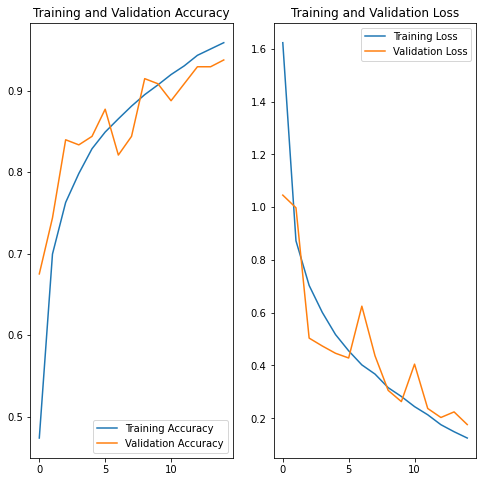

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

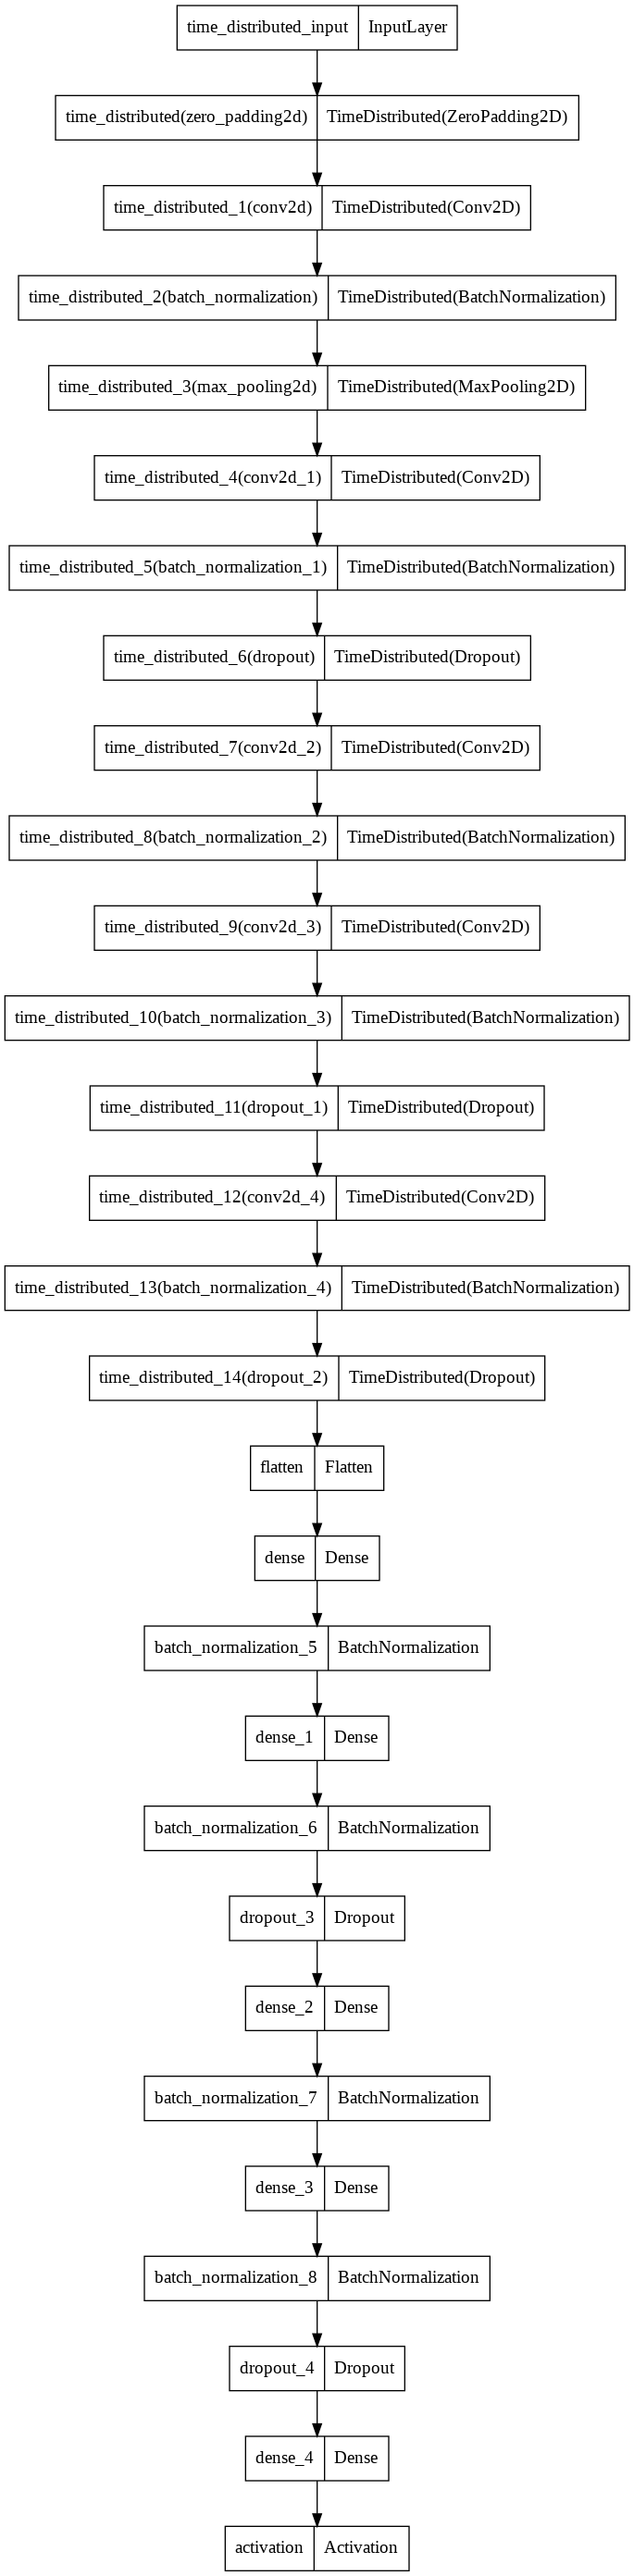

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')